In [1]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import glob
import shutil
import os
from get_center import get_center

In [2]:
path = '/Users/ha/Makani_Project/'
lst_raw = glob.glob(path + '/data/*/*/*raw.fits')
dark_lst = glob.glob(path + '/darks/HST/*/*raw.fits')

Function to create an average dark from archived data knowing a upper temperature

Flag out the galaxy from each frame ( real data )

In [3]:
%%time
#dark_file = fits.open('avg_dark_archived_uppertemp24.fits')
total_exptime = 0

for i in range(len(lst_raw)):
    flaged_table = np.ones((1024,1024))
    flaged_subtracted = np.zeros((1024, 1024))
    
    filename = lst_raw[i]
    rawfile = fits.open(filename)
    rawdata = rawfile[1].data
    exptime = rawfile[0].header['EXPTIME']
    rootname = rawfile[0].header['ROOTNAME']
    
    x_center, y_center = get_center(filename)
    if np.isnan(x_center) or np.isnan(y_center):
        continue
    x_center, y_center = int(x_center), int(y_center)    
    
    #flag_table; flag_subtracted table
    flaged_subtracted = fits.open(filename)[1].data
    
    e = 30
    for i in range(y_center -e, y_center + e):
        for j in range(x_center - e, x_center + e):
            flaged_table[i][j] = 0.0
            flaged_subtracted[i][j] = 0

            
    #create a flaged file
    Primary = rawfile['Primary']
    SCI = fits.ImageHDU(rawdata, name = 'SCI', header = rawfile['SCI'].header)
    FLAG = fits.ImageHDU(flaged_table, name = 'FLAG')
    FLAG_subtracted = fits.ImageHDU(flaged_subtracted, name = 'FS')
    hdul = fits.HDUList([Primary, SCI, FLAG, FLAG_subtracted])
    hdul.writeto(rootname + '_flaged.fits', overwrite = True)
    
    
    #create a subtracted file
    #dark_frame = dark_file[0].data * exptime
    #new_data = rawdata - dark_frame
    
    #subtracted_SCI = fits.ImageHDU(new_data, name = 'SCI', header = rawfile['SCI'].header)
    #subtracted_hdul = fits.HDUList([Primary, subtracted_SCI, FLAG])
    #subtracted_hdul.writeto(filename[-18:-9] + '_subtracted_24.fits', overwrite = True)
    

/Users/ha/Makani_Project/Testxxi/get_center.py:55: RuntimeWarning: invalid value encountered in long_scalars
  i_center = i_integral/total_flux
/Users/ha/Makani_Project/Testxxi/get_center.py:56: RuntimeWarning: invalid value encountered in long_scalars
  j_center = j_integral/total_flux


CPU times: user 5.23 s, sys: 1.47 s, total: 6.7 s
Wall time: 9.46 s


In [4]:
directory_name = 'flaged'
parent_path = '/Users/ha/Makani_Project/Testxxi'
path = os.path.join(parent_path, directory_name)
os.makedirs(path)

In [5]:
old_flaged_lst = glob.glob('*_flaged.fits')
for files_path in old_flaged_lst:
    shutil.move(files_path, path)

Combine all the flaged file to create a new dark frame

In [6]:
%%time
flaged_lst =  glob.glob('flaged/*_flaged.fits')
sumdata_1subtracted = np.zeros((1024,1024))
exptime_table = np.zeros((1024,1024))
for filename in flaged_lst:
        file = fits.open(filename)
        data = file[1].data
        flaged_table = file['FLAG'].data
        flaged_subtracted = file['FS'].data
        exptime = file[0].header['EXPTIME']

        exptime_table += exptime * flaged_table
        sumdata_1subtracted += flaged_subtracted
        #print(file[0].header['DATE'])
for i in range(0, 1024):
    for j in range(0, 1024):
        sumdata_1subtracted[i][j] /= exptime_table[i][j]

Primary = fits.PrimaryHDU()
SCI = fits.ImageHDU(sumdata_1subtracted, name = 'SCI')
hdul = fits.HDUList([Primary, SCI])
hdul.writeto('avg_dark_summed_data.fits', overwrite = True)

CPU times: user 891 ms, sys: 247 ms, total: 1.14 s
Wall time: 3.33 s


In [7]:
arch_temp_2022 = []
arch_darks_2022 = []
for item in dark_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE-OBS'][:4])
    data_ps = file[1].data/ exptime
    
    if year == 2022 and temp >= 0.0 and temp <= 30.0:
        arch_temp_2022.append(temp)
        sample = data_ps[471: 822, 471:822]
        darks = sum(sum(sample)) / (len(sample) * len(sample[0]))
        arch_darks_2022.append(darks)

arch_temp_2021 = []
arch_darks_2021 = []
for item in dark_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE-OBS'][:4])
    data_ps = file[1].data/ exptime
    
    if year == 2021 and temp >= 0.0 and temp <= 30.0:
        arch_temp_2021.append(temp)
        sample = data_ps[471: 822, 471:822]
        darks = sum(sum(sample)) / (len(sample) * len(sample[0]))
        arch_darks_2021.append(darks)
        
arch_temp_2020 = []
arch_darks_2020 = []
for item in dark_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE-OBS'][:4])
    data_ps = file[1].data/ exptime
    
    if year == 2020 and temp >= 0.0 and temp <= 30.0:
        arch_temp_2020.append(temp)
        sample = data_ps[471: 822, 471:822]
        darks = sum(sum(sample)) / (len(sample) * len(sample[0]))
        arch_darks_2020.append(darks)
        
data_temp = []
data_darks = []
for item in flaged_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    data_ps = file[1].data/ exptime
    
    data_temp.append(temp)
    sample = data_ps[471:822 , 471:822]
    darks = sum(sum(sample)) /( (len(sample) * len(sample[0])) - (2*e)**2)
    data_darks.append(darks)


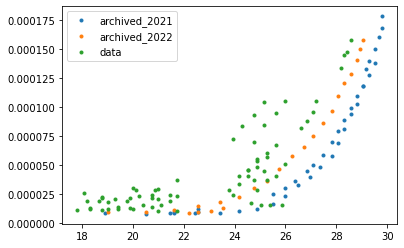

In [8]:
#plt.plot(arch_temp_2020, arch_darks_2020, '.', label = 'archived_2020')    
plt.plot(arch_temp_2021, arch_darks_2021, '.', label = 'archived_2021')
plt.plot(arch_temp_2022, arch_darks_2022, '.', label = 'archived_2022')
plt.plot(data_temp, data_darks, '.', label = 'data')
plt.legend()

In [9]:
data_temp = []
data_darks = []
visit_lst = [1, 3, 4, 5, 7, 8, 9, 10, 56, 57, 58]
for visit_num in visit_lst:
    l = []
    t = []
    for item in flaged_lst:
        file = fits.open(item)
        exptime = file[0].header['EXPTIME']
        temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
        year = (file[0].header['DATE-OBS'])
        data_ps = file[1].data/ exptime
        visit = int(file[0].header['LINENUM'][:2])
        
        if visit == visit_num:
            #print(visit_num, year)

            t.append(temp)
            sample = data_ps[471:822 , 471:822]
            #sample = data_ps
            darks = sum(sum(sample)) /( (len(sample) * len(sample[0])) - (2*e)**2)
            l.append(darks)
    data_darks.append(l)
    data_temp.append(t)

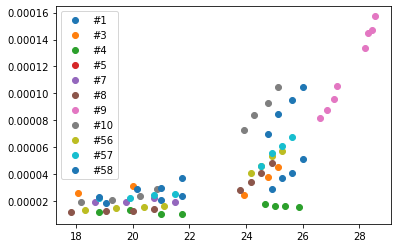

In [10]:
for i in range(len(data_darks)):
    plt.plot(data_temp[i], data_darks[i], 'o', label = '#'+str(visit_lst[i]))
    plt.legend()
    #plt.show()

Create primary dark

# CHECKPOINT

In [11]:
uptemp = 20

In [12]:
%%time
sumdata_1subtracted = np.zeros((1024,1024))
exptime_table = np.zeros((1024,1024))
num_files_combined = 0
for filename in flaged_lst:
    file = fits.open(filename)
    data = file[1].data
    flaged_table = file['FLAG'].data
    flaged_subtracted = file['FS'].data
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
        
    if temp > uptemp:
        continue
    num_files_combined += 1
    exptime_table += exptime * flaged_table
    sumdata_1subtracted += flaged_subtracted
        
for filename in dark_lst:
    file = fits.open(filename)
    data = file[1].data
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    flaged_table = np.ones((1024, 1024))
    year = int(file[0].header['DATE-OBS'][:4])
    if temp <= uptemp and temp >= 0.0 and year >= 2019:
        num_files_combined += 1
        exptime_table += exptime * flaged_table
        sumdata_1subtracted += data

for i in range(0, 1024):
    for j in range(0, 1024):
        sumdata_1subtracted[i][j] /= exptime_table[i][j]

print(num_files_combined)
Primary = fits.PrimaryHDU()
SCI = fits.ImageHDU(sumdata_1subtracted, name = 'SCI')
hdul = fits.HDUList([Primary, SCI])
hdul.writeto('primary_dark_uptemp_'+str(uptemp)+'.fits', overwrite = True)

25
CPU times: user 1.95 s, sys: 144 ms, total: 2.1 s
Wall time: 2.25 s


Primary Dark Subtraction

In [13]:
pri_dark = fits.open('primary_dark_uptemp_'+str(uptemp)+'.fits')
dark_data = pri_dark[1].data

for filename in flaged_lst:
    file = fits.open(filename)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    real_data = file[1].data
    rootname = file[0].header['ROOTNAME']
    new_data = real_data - dark_data * exptime 
    
    Primary = file[0]
    SCI = fits.ImageHDU(new_data, header = file[1].header, name = 'SCI')
    
    hdul = fits.HDUList([Primary, SCI])
    
    hdul.writeto(rootname + '_1subtracted_'+str(uptemp)+'.fits', overwrite = True)

In [14]:
directory_name = '1subtracted_' + str(uptemp)
parent_path = '/Users/ha/Makani_Project/Testxxi'
path = os.path.join(parent_path, directory_name)
os.makedirs(path)

In [15]:
old_1subtracted_lst = glob.glob('*_1subtracted_'+str(uptemp)+'.fits')
for files_path in old_1subtracted_lst:
    shutil.move(files_path, path)

In [16]:
pri_subtracted_lst = glob.glob('1subtracted_'+str(uptemp)+'/*_1subtracted_'+str(uptemp)+'.fits')

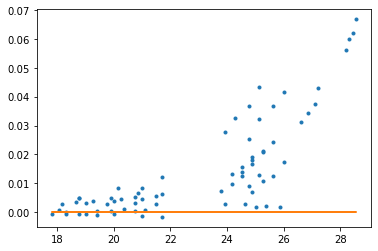

In [17]:
width_2dark = 300
x_2dark = 600
y_2dark = 650
temps = []
res = []
for filename in pri_subtracted_lst:
    #print(filename)
    file = fits.open(filename)
    data = file[1].data
    
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    X_center = int(get_center(filename)[0])
    Y_center = int(get_center(filename)[1])
    
    e = 50
    for i in range(Y_center - e, Y_center + e):
        for j in range(X_center - e, X_center + e):
            data[i][j] = 0
    sample = data[y_2dark - width_2dark: y_2dark + width_2dark,
                                   x_2dark - width_2dark: x_2dark + width_2dark]

    temps.append(temp)
    res.append( sum(sum(sample)) / (sample.size - e**2) )    

#temps_24 = []
#res_24 = []
#for filename in pri_subtracted_lst_24:
#    #print(filename)
#    file = fits.open(filename)
#    data = file[1].data
#    
#    exptime = file[0].header['EXPTIME']
#    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
#    X_center = int(get_center(filename)[0])
#    Y_center = int(get_center(filename)[1])
#    
#    e = 50
#    for i in range(Y_center - e, Y_center + e):
#        for j in range(X_center - e, X_center + e):
#            data[i][j] = 0
#    sample = data[y_2dark - width_2dark: y_2dark + width_2dark,
#                                   x_2dark - width_2dark: x_2dark + width_2dark]
#    
#    temps_24.append(temp)
#    res_24.append( sum(sum(sample)) / (sample.size - e**2) )
plt.plot(temps, res, '.')
plt.plot(temps, [0] * len(temps))
#plt.plot(temps_24, res_24, '.')

In [18]:
res.sort()
res

[-0.0017840440664798314,
 -0.001419155102342666,
 -0.0009935575318886073,
 -0.0008879972061105299,
 -0.000871110680640292,
 -0.000858112215125906,
 -0.0008333131176367775,
 -0.0007137457370067635,
 -0.00013626749892962063,
 0.0002429909024384699,
 0.00029750621424071534,
 0.0003083035771508852,
 0.0006460859538695232,
 0.0007163389874078227,
 0.0008176609286622886,
 0.0016094608040944241,
 0.0017604747114736204,
 0.0019707679352081,
 0.0025466949379997837,
 0.0026228704552555353,
 0.0026818093508797704,
 0.002695938489112696,
 0.002785409904922633,
 0.003058222172407084,
 0.0032156582204149776,
 0.003330526638319414,
 0.0036185163939246945,
 0.003708789006456404,
 0.00438716270454988,
 0.004396041796064862,
 0.004634900901512954,
 0.004635685479518479,
 0.004654566947226048,
 0.00496959143097939,
 0.005593072908933937,
 0.006264344250488634,
 0.006681438844138068,
 0.006735216940229589,
 0.007288510507345614,
 0.008170594087274538,
 0.008199483711403523,
 0.008866220263776075,
 0.00979

Create secondary dark

In [19]:
pri_dark = fits.open('primary_dark_uptemp_'+str(uptemp)+'.fits')
real_dark = fits.open('avg_dark_summed_data.fits')

pri_dark_data = pri_dark[1].data
real_dark_data = real_dark[1].data

data = real_dark_data - pri_dark_data
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('secondary_dark_'+str(uptemp)+'.fits', overwrite = True)

Secondary Dark Subtraction

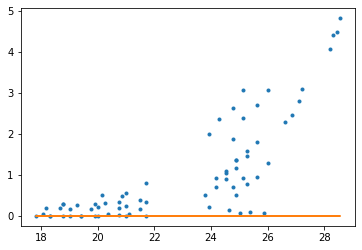

CPU times: user 9.06 s, sys: 1.11 s, total: 10.2 s
Wall time: 12.4 s


In [20]:
%%time
width_2dark = 200
x_2dark = 600
y_2dark = 650
sec_dark = fits.open('secondary_dark_'+str(uptemp)+'.fits')
data_2dark = sec_dark[0].data
sec_dark_sample = data_2dark[y_2dark - width_2dark: y_2dark + width_2dark,
                                   x_2dark - width_2dark: x_2dark + width_2dark]
A_2dark_ps = sum(sum(sec_dark_sample)) / (sec_dark_sample.size) 

temps = []
coeffs = []
for filename in pri_subtracted_lst:
    file = fits.open(filename)
    data = file[1].data
    
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    rootname = file[0].header['ROOTNAME']
    X_center = int(get_center(filename)[0])
    Y_center = int(get_center(filename)[1])
    
    
    sumdata = 0
    num_val = 0
    e = 50
    for i in range(y_2dark - width_2dark, y_2dark + width_2dark):
        for j in range(x_2dark - width_2dark, x_2dark + width_2dark):
            if i >= Y_center - e and i < Y_center + e and j >= X_center - e and j< X_center + e:
                continue
            sumdata += data[i][j]
            num_val += 1
    
    A_data = sumdata/ num_val 
    
    k = A_data/( A_2dark_ps * exptime) 
    if k < 0:
        k = 0
    coeffs.append(k)
    temps.append(temp)
    
    new_data = data - k * data_2dark * exptime
    Primary = file[0]
    SCI = fits.ImageHDU(new_data, header = file[1].header, name = 'SCI')
    
    hdul = fits.HDUList([Primary, SCI])
    
    hdul.writeto(rootname + '_2subtracted_'+str(uptemp)+'.fits', overwrite = True)
    #print(temp, np.median(coeff))
plt.plot(temps,coeffs, '.')
plt.plot(temps, [0] * len(temps))
plt.show()

In [21]:
coeffs.sort()
coeffs

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.004667304218437747,
 0.0059941547279563885,
 0.012429178188641662,
 0.03912427923415753,
 0.048768860867341925,
 0.05582510993116207,
 0.07594105574469388,
 0.07878586310401266,
 0.08973392549055459,
 0.1487447528784301,
 0.16073842165207447,
 0.1695533364655114,
 0.17130224858220064,
 0.18814583114432065,
 0.18925423236406533,
 0.19648166769703299,
 0.20538865569636408,
 0.2179207214926606,
 0.24593485836720053,
 0.2580264962162845,
 0.2826835173330269,
 0.28444757959898265,
 0.2915038286628046,
 0.32343615673383597,
 0.34408368540777146,
 0.34595920179277284,
 0.3892328781966333,
 0.49629671735599123,
 0.49972179025477315,
 0.5017775233058875,
 0.5201262983302019,
 0.5466104259705955,
 0.6973689046070867,
 0.7015286234243842,
 0.7767553539826287,
 0.8056665177223776,
 0.904511520894456,
 0.9140070228295669,
 0.926988550869992,
 0.9361569613900703,
 1.0410091508740895,
 1.094773244852906,
 1.157021535316243,
 1.2788669031633577,
 1.36439468213202

In [22]:
directory_name = '2subtracted_' + str(uptemp)
parent_path = '/Users/ha/Makani_Project/Testxxi'
path = os.path.join(parent_path, directory_name)
os.makedirs(path)

In [23]:
old_2subtracted_lst = glob.glob('*_2subtracted_'+str(uptemp)+'.fits')
for files_path in old_2subtracted_lst:
    shutil.move(files_path, path)

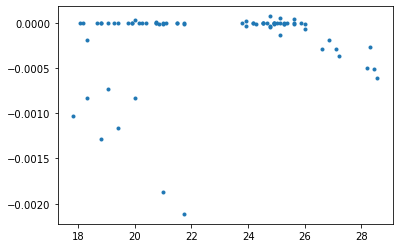

In [24]:
#sec_subtracted_lst_24 = glob.glob('2subtracted_'+str(24)+'/*_2subtracted_'+str(24)+'.fits')
sec_subtracted_lst = glob.glob('2subtracted_'+str(uptemp)+'/*_2subtracted_'+str(uptemp)+'.fits')
temps_20 = []
res_20 = []
for filename in sec_subtracted_lst:
    #print(filename)
    file = fits.open(filename)
    data = file[1].data
    
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    X_center = int(get_center(filename)[0])
    Y_center = int(get_center(filename)[1])
    
    e = 50
    for i in range(Y_center - e, Y_center + e):
        for j in range(X_center - e, X_center + e):
            data[i][j] = 0
    
    sample = data[y_2dark - width_2dark: y_2dark + width_2dark,
                                   x_2dark - width_2dark: x_2dark + width_2dark]    
    temps_20.append(temp)
    res_20.append( sum(sum(sample)) / (sample.size - e**2) )    

#temps_24 = []
#res_24 = []
#for filename in sec_subtracted_lst_24:
#    #print(filename)
#    file = fits.open(filename)
#    data = file[1].data
    
#    exptime = file[0].header['EXPTIME']
#    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
#    X_center = int(get_center(filename)[0])
#    Y_center = int(get_center(filename)[1])
    
#    e = 50
#    for i in range(Y_center - e, Y_center + e):
#        for j in range(X_center - e, X_center + e):
#            data[i][j] = 0
#    sample = data[y_2dark - width_2dark: y_2dark + width_2dark,
#                                   x_2dark - width_2dark: x_2dark + width_2dark]
    
#    temps_24.append(temp)
#    res_24.append( sum(sum(sample)) / (sample.size - e**2) )
plt.plot(temps_20, res_20, '.')
#plt.plot(temps_24, res_24, '.')